<a href="https://colab.research.google.com/github/not-sid-29/building-scratch-neural-nets/blob/main/Random_forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Forest on tabular data:

**Dataset used:** [Titanic Survival Dataset](https://www.kaggle.com/competitions/titanic)

In [ ]:
#basic imports for data:
from fastai.imports import *
np.set_printoptions(linewidth=150)

## I. Data Preprocessing

- Downloading the dataset:

In [ ]:
#basic shell commands required for colab environment:

!mkdir ~/.kaggle
!mv /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
import os
from pathlib import Path
is_kaggle = os.environ.get("KAGGLE_KERNEL_RUN_TYPE", "")

if is_kaggle:
  path = Path("../input/titanic")
else:
  import zipfile,kaggle
  path = Path('titanic')
  kaggle.api.competition_download_cli(str(path))
  zipfile.ZipFile(f'{path}.zip').extractall(path)



100%|██████████| 34.1k/34.1k [00:00<00:00, 11.9MB/s]

- Loading the dataset:


In [ ]:
df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')


In [ ]:
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


- Data Preprocessing:

In [ ]:
import pandas as pd

modes = df.mode().iloc[0]


def preproc_data(df):
  df['Fare'] = df.Fare.fillna(0)
  df.fillna(modes, inplace = True)
  df['LogFare'] = np.log1p(df['Fare']) #converting Fare values to Log(fare + 1), to scale the data
  df['Embarked'] = pd.Categorical(df.Embarked)
  df['Sex'] = pd.Categorical(df.Sex)



preproc_data(df)
preproc_data(test_df)



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Name         891 non-null    object  
 4   Sex          891 non-null    category
 5   Age          891 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        891 non-null    object  
 11  Embarked     891 non-null    category
 12  LogFare      891 non-null    float64 
dtypes: category(2), float64(3), int64(5), object(3)
memory usage: 78.7+ KB


In [ ]:
#Creating a list of A)Continous Features; B)Categorical Features; C)Dependent Features.

categorical = ["Sex", "Embarked"]
continous = ["Age", "SibSp", "Parch", "LogFare", "Pclass"]
dependent = "Survived"


In [ ]:
#How does pd.Categorical affect the Sex Column

df.Sex.head(5)

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: category
Categories (2, object): ['female', 'male']

In [ ]:
df.Sex.cat.codes.head(5)

0    1
1    0
2    0
3    0
4    1
dtype: int8

- Behind the scenes, it stores the Male, Female as numeric values.<br>


> 1 == Male<br>


> 0 == Female





## II. Binary Splits: <br>



> A Gradient Boosting Machine(GBMs) or RandomForests is an ensemble of Decision Trees.


> And Decision Trees are an ensemble of Binary Splits(Categorizing the data into 2 classes/categories)





[Text(0.5, 1.0, 'Distribution as per Sex')]

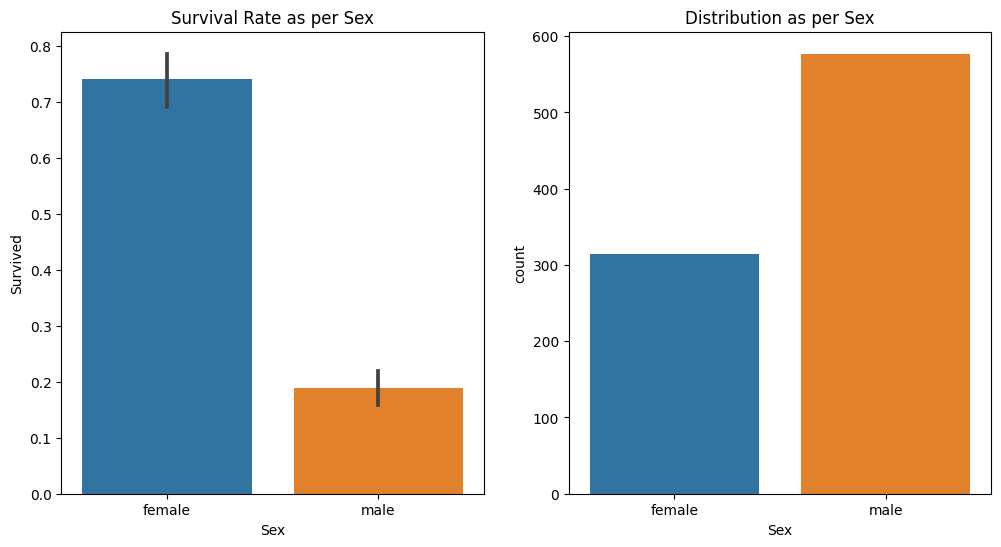

In [ ]:
import seaborn as sns


fig, axs = plt.subplots(1, 2, figsize = (12, 6))

sns.barplot(data=df, y=dependent, x="Sex", ax=axs[0]).set(title="Survival Rate as per Sex")
sns.countplot(data=df, x="Sex", ax=axs[1]).set(title="Distribution as per Sex")

- **Insights from the graph**:<br>
1. The survival rate for female is much higher as compared to males,(survival is >70% for females, and ~20% for males)<br>
2. The number of passengers are 300 females and >500 for males

### Creating a base model or a dumb model: that predicts only Females Survived and no Males survived.


In [ ]:

from numpy import random
from sklearn.model_selection import train_test_split

random.seed(24)
train_df, valid_df = train_test_split(df, test_size=0.30)
train_df[categorical] = train_df[categorical].apply(lambda x: x.cat.codes)
valid_df[categorical] = valid_df[categorical].apply(lambda x: x.cat.codes)

In [ ]:
#Creating the dependent(y variable) and independent variable(x variable)

def create_variables(df):
  xs = df[categorical+continous].copy()
  return xs, df[dependent] if dependent in df else None


train_xs, train_y = create_variables(train_df)
valid_xs, valid_y = create_variables(valid_df)

In [ ]:
#Creating predictions using a dumb model:


preds = valid_xs.Sex==0
preds

169    False
556     True
206    False
71      True
677     True
       ...  
88      True
494    False
316     True
153    False
802    False
Name: Sex, Length: 268, dtype: bool

In [ ]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(valid_y, preds)

0.19776119402985073

the MAE on the "Sex" split is 0.197, ie. our base model predicts the Survival based on sex, with an accuracy of ~81%

### Creating a Binary Split model on LogFare splits:

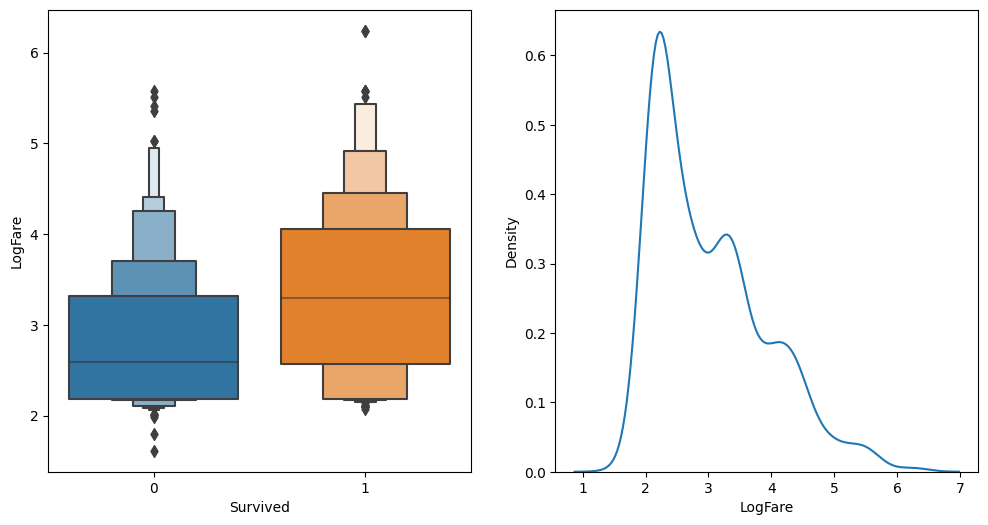

In [ ]:
df_fare = train_df[train_df.LogFare > 0]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.boxenplot(data=df_fare, x=dependent, y="LogFare", ax=axs[0])
sns.kdeplot(data=df_fare, x="LogFare", ax=axs[1]);

**Insights**:<br>
- Median Fare for Survived=0 is 2.5;<br>

- Median Fare for Survived=1 is 3.2.  

**Creating a baseline model with threshold value: 2.7**

In [ ]:
preds_fare = valid_xs.LogFare > 2.7
mean_absolute_error(valid_y, preds_fare)

0.34701492537313433

Here, the MAE scored for "LogFare" splits is around 0.34, hence this baseline model cannot predict as accurately as our "Sex-Split" base model


In [ ]:
##Defining a helper function, to help us calculate similarity scores between two groups using standard deviaiation


def split_side_score(side, y):
  total = side.sum() #sampling the size of side of a split
  if total <= 1: #if the group is very very small return 0
    return 0
  return y[side].std() * total #return the stnd deviation of the predicted values of the split side and multiplying with the size of the split


In [ ]:
#Calculating the impurity score on the splits(left-hand side and right-hand side)
def similar_score(col, y, split):
  left_side = col <= split
  return (split_side_score(left_side, y) + split_side_score(~left_side, y))/len(y)

In [ ]:
similar_score(train_xs["Sex"], train_y, 0.5)

0.41369862538915464

In [ ]:
similar_score(train_xs["LogFare"], train_y, 2.7)

0.47556584743944735

In [ ]:
df.Age.unique()

array([22.  , 38.  , 26.  , 35.  , 24.  , 54.  ,  2.  , 27.  , 14.  ,  4.  , 58.  , 20.  , 39.  , 55.  , 31.  , 34.  , 15.  , 28.  ,  8.  , 19.  ,
       40.  , 66.  , 42.  , 21.  , 18.  ,  3.  ,  7.  , 49.  , 29.  , 65.  , 28.5 ,  5.  , 11.  , 45.  , 17.  , 32.  , 16.  , 25.  ,  0.83, 30.  ,
       33.  , 23.  , 46.  , 59.  , 71.  , 37.  , 47.  , 14.5 , 70.5 , 32.5 , 12.  ,  9.  , 36.5 , 51.  , 55.5 , 40.5 , 44.  ,  1.  , 61.  , 56.  ,
       50.  , 36.  , 45.5 , 20.5 , 62.  , 41.  , 52.  , 63.  , 23.5 ,  0.92, 43.  , 60.  , 10.  , 64.  , 13.  , 48.  ,  0.75, 53.  , 57.  , 80.  ,
       70.  , 24.5 ,  6.  ,  0.67, 30.5 ,  0.42, 34.5 , 74.  ])

In [ ]:
#Creating a GUI to create a widget that shows us the "similar_score" amongst the features present in the dataset.

def calc_score(feature, split):
  cols = train_xs[feature]
  return similar_score(cols, train_y, split)

#For continous features:
from ipywidgets import interact

interact(feature=continous, split=15)(calc_score);

interactive(children=(Dropdown(description='feature', options=('Age', 'SibSp', 'Parch', 'LogFare', 'Pclass'), …

In [ ]:
#For categorical feature

interact(feature=categorical, split=1)(calc_score);

interactive(children=(Dropdown(description='feature', options=('Sex', 'Embarked'), value='Sex'), IntSlider(val…

- **Automating the process of selecting best splits**:

In [ ]:
feature = "Age" #automating the best split for age
col = train_xs[feature]
unique_vals = col.unique()
unique_vals.sort()
unique_vals

array([ 0.42,  0.67,  0.75,  0.83,  0.92,  1.  ,  2.  ,  3.  ,  4.  ,  5.  ,  6.  ,  7.  ,  8.  ,  9.  , 10.  , 11.  , 13.  , 14.  , 15.  , 16.  ,
       17.  , 18.  , 19.  , 20.  , 20.5 , 21.  , 22.  , 23.  , 23.5 , 24.  , 24.5 , 25.  , 26.  , 27.  , 28.  , 28.5 , 29.  , 30.  , 30.5 , 31.  ,
       32.  , 32.5 , 33.  , 34.  , 34.5 , 35.  , 36.  , 36.5 , 37.  , 38.  , 39.  , 40.  , 40.5 , 41.  , 42.  , 43.  , 44.  , 45.  , 45.5 , 46.  ,
       47.  , 48.  , 49.  , 50.  , 51.  , 52.  , 53.  , 54.  , 55.  , 55.5 , 57.  , 58.  , 59.  , 60.  , 61.  , 62.  , 63.  , 64.  , 65.  , 70.  ,
       71.  , 74.  ])

In [ ]:
scores = np.array([similar_score(col, train_y, o) for o in unique_vals if not np.isnan(o)])
unique_vals[scores.argmin()]

0.92

**Remarks**:<br>
1. The minimum cutoff for "Age" feature for the best split comes out to be 0.92

In [ ]:
#Defining a helper function to find out the best splits for all the features in data:

def minSplit(df, feature):
  col, y = df[feature], df[dependent]
  unique_vals = col.dropna().unique()
  scores = np.array([similar_score(col, y, o) for o in unique_vals if not np.isnan(o)])
  idx = scores.argmin()
  return unique_vals[idx], scores[idx]

In [ ]:
minSplit(train_df, feature="Age")

(0.92, 0.48357809829077847)

In [ ]:
#For all present columns in the dataset:

features = continous + categorical

{o : minSplit(train_df, o) for o in features}

{'Age': (0.92, 0.48357809829077847),
 'SibSp': (3, 0.4832519077393656),
 'Parch': (0, 0.4846610524256157),
 'LogFare': (3.970291913552122, 0.46782085131297524),
 'Pclass': (2, 0.4668681738579788),
 'Sex': (0, 0.41369862538915464),
 'Embarked': (1, 0.48440522462648106)}

- This model approach is the **OneR** classifier


## III. Creating a DecisionTree model to improve our OneR classifier:

**Improvement of OneR Classifier:**<br>
1. We can make sub-splits for every group, ex. this approach can define *best split for males* and *best split for females* to improve the accuracy of the model

In [ ]:
features

['Age', 'SibSp', 'Parch', 'LogFare', 'Pclass', 'Sex', 'Embarked']

In [ ]:
features.remove("Sex")

is_male = train_df.Sex==1
males, females = train_df[is_male], train_df[~is_male]


**Finding best splits for *Males* and *Females***

In [ ]:
{o : minSplit(males, o) for o in features}

{'Age': (3.0, 0.3875234199820683),
 'SibSp': (2, 0.39007198727881687),
 'Parch': (0, 0.3959083647237127),
 'LogFare': (2.7788192719904172, 0.3849713490050445),
 'Pclass': (1, 0.3892004863813556),
 'Embarked': (0, 0.39836482268217077)}

In [ ]:
{f : minSplit(females, f) for f in features}

{'Age': (50.0, 0.42061229298575675),
 'SibSp': (2, 0.4152082762354819),
 'Parch': (3, 0.41697085452881855),
 'LogFare': (3.8691155044168695, 0.40794137004230346),
 'Pclass': (2, 0.3655465770364353),
 'Embarked': (0, 0.4270035434368538)}

**Best Split values and Best Scores**:<br>


1.   *Males*:<br>

> For __AGE__: 3.0<br>
> For __Pclass__: 1


2.   *Females*:<br>

> For __AGE__: 50.0<br>
> For __Pclass__: 2



**Building a DecisionTreeClassifier**:

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

dtree = DecisionTreeClassifier(max_leaf_nodes = 6).fit(train_xs, train_y)

- **Visualising the *DecisionTreeClassifier***

In [ ]:
import graphviz
def draw_dtree(tree_obj, dataframe, size=10, ratio=0.65, precision=2, **kwargs):
  s  = export_graphviz(tree_obj, out_file=None, feature_names=dataframe.columns, filled=True, rounded=True,
                       special_characters=True, rotate=False, precision=precision, **kwargs)
  return graphviz.Source(re.sub('Tree {', f"Tree {{ size={size}; ratio={ratio}", s))


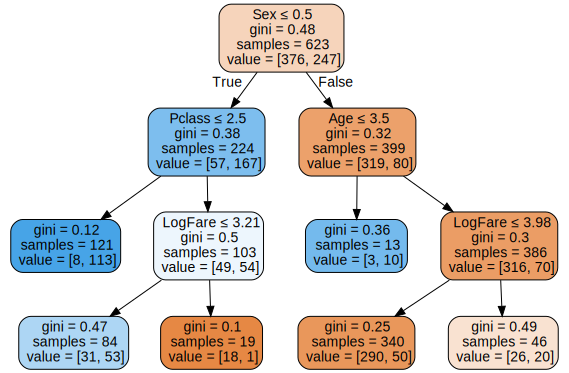

In [ ]:
draw_dtree(dtree, train_xs, size=10)

In [ ]:
#Defining a gini impurity function:

def gini_impurity(condition):
  actual = df.loc[condition, dependent]
  return 1 - actual.mean()**2 - (1-actual).mean()**2  #returning the gini impurity


In [ ]:
#calculating Gini Impurity of the Sex-Split:

print(gini_impurity(df.Sex=='female'))
print(gini_impurity(df.Sex=='male'))


0.3828350034484158
0.3064437162277842


**Comparison of DecisionTree Model Vs. OneR model**

In [ ]:
mean_absolute_error(valid_y, dtree.predict(valid_xs))

0.1828358208955224

- MAE for DTree model = 0.182<br>
- MAE for OneR model = 0.197<br>
 *Our Decision tree model is slightly better than the OneR model(on Sex split)*

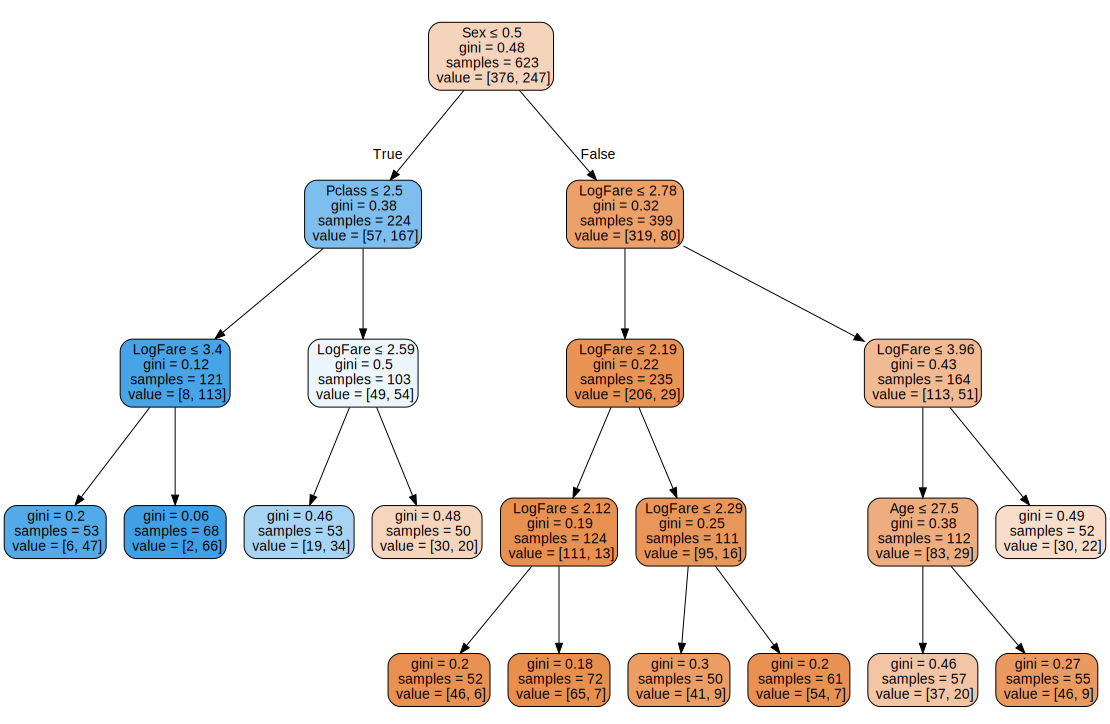

In [ ]:
#Improving the DecisionTree model:

dtree_2 = DecisionTreeClassifier(min_samples_leaf=50) #minimum samples per leaf will be 50
dtree_2.fit(train_xs, train_y)
draw_dtree(dtree_2, train_xs, size=20)

In [ ]:
mean_absolute_error(valid_y, dtree_2.predict(valid_xs))

0.1865671641791045

- MAE of 2nd DTree model(min. 50 samples/leaf) = 0.186<br>
- MAE of 1st DTree model(with max leaf nodes = 6) = 0.182

In [ ]:
test_df.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,B96 B98,Q,2.178064
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,B96 B98,S,2.079442
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,B96 B98,Q,2.369075
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,B96 B98,S,2.268252
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,B96 B98,S,2.586824
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,B96 B98,S,2.324836
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,B96 B98,Q,2.155152
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,B96 B98,S,3.401197
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,B96 B98,C,2.107689
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,B96 B98,S,3.224858


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  418 non-null    int64   
 1   Pclass       418 non-null    int64   
 2   Name         418 non-null    object  
 3   Sex          418 non-null    category
 4   Age          418 non-null    float64 
 5   SibSp        418 non-null    int64   
 6   Parch        418 non-null    int64   
 7   Ticket       418 non-null    object  
 8   Fare         418 non-null    float64 
 9   Cabin        418 non-null    object  
 10  Embarked     418 non-null    category
 11  LogFare      418 non-null    float64 
dtypes: category(2), float64(3), int64(4), object(3)
memory usage: 33.8+ KB


In [ ]:
test_df[categorical] = test_df[categorical].apply(lambda x: x.cat.codes)
test_xs, _ = create_variables(test_df)


def submit_func(preds, suffix):
  test_df['Survived'] = preds
  submit_df = test_df[['PassengerId', 'Survived']]
  submit_df.to_csv(f'submit-{suffix}.csv', index=False)


submit_func(dtree.predict(test_xs), 'tree-model')

##IV. Creating RandomForest Model:

**RandomForest** is a bagging model, which consists of multiple decision tree models underneath it. The Decision Tree models are trained on random subset of the dataset, and then their errors and predictions are averaged(mean error ∼ 0) and the mean of the predictions of multiple decision trees is better than predictions made by one underlying decision tree.

In [ ]:
def get_tree(proportion = 0.50):
  n = len(train_y)
  idxs = random.choice(n, int(n*proportion))
  return DecisionTreeClassifier(min_samples_leaf = 10).fit(train_xs.iloc[idxs], train_y.iloc[idxs])

In [ ]:
forest = [get_tree() for t in range(100)]

In [ ]:
all_preds = [t.predict(valid_xs) for t in forest]

mean_preds = np.stack(all_preds).mean(0)


mean_absolute_error(valid_y, mean_preds)

0.19294776119402982

### Using Sklearn's RandomForest model:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=10)
rf.fit(train_xs, train_y)
mean_absolute_error(valid_y, rf.predict(valid_xs))

0.16417910447761194

In [ ]:
submit_func(rf.predict(test_xs), '-rf')

# V. Feature Importance using RandomForests:

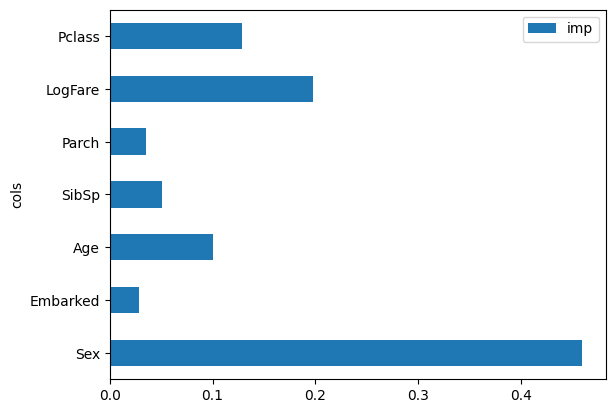

In [ ]:
#plotting the feature importance using rf helps in deciding important features in large datasets:

pd.DataFrame(dict(cols = train_xs.columns, imp = rf.feature_importances_)).plot('cols', 'imp', 'barh');